In [5]:
import os
import getpass
from huggingface_hub import login  # Import the login function

hf_token = getpass.getpass("Enter your Hugging Face token: ")
os.environ["HUGGINGFACE_TOKEN"] = hf_token  # Optional, but not required for login
login(token=hf_token)  # Use the imported login function


Enter your Hugging Face token:  ········


# Advanced Models: Train LSTM/GRU models for sequence-based learning.

Importing necessary packages
--

In [6]:
import os
import json
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from transformers import (
    AutoTokenizer, AutoModel, get_linear_schedule_with_warmup,
    AdamW, AutoConfig
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")


Loading the dataset
--

In [7]:
def load_data():
    """
    Load and prepare all data.
    
    Returns:
        Dictionary containing processed data and features
    """
    logger.info("Loading preprocessed data...")
    processed_train = pd.read_csv('/kaggle/input/sm-tec-generated-dataset/multilingual_processed_train_text.csv')
    processed_val = pd.read_csv('/kaggle/input/sm-tec-generated-dataset/multilingual_processed_val_text.csv')
    
    logger.info("Loading TF-IDF features...")
    train_tfidf = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_tfidf_features.npy')
    val_tfidf = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_tfidf_features.npy')
    
    logger.info("Loading Word2Vec features...")
    train_premise_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_premise_w2v.npy')
    train_hypothesis_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_train_hypothesis_w2v.npy')
    val_premise_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_premise_w2v.npy')
    val_hypothesis_w2v = np.load('/kaggle/input/sm-tec-generated-dataset/multilingual_val_hypothesis_w2v.npy')
    
    # Combine Word2Vec features
    train_w2v_combined = np.concatenate([train_premise_w2v, train_hypothesis_w2v, 
                                       train_premise_w2v - train_hypothesis_w2v,
                                       np.multiply(train_premise_w2v, train_hypothesis_w2v)], axis=1)
    val_w2v_combined = np.concatenate([val_premise_w2v, val_hypothesis_w2v, 
                                     val_premise_w2v - val_hypothesis_w2v,
                                     np.multiply(val_premise_w2v, val_hypothesis_w2v)], axis=1)
    
    # Print shapes to debug
    print(f"Original data shapes:")
    print(f"processed_train: {processed_train.shape}")
    print(f"processed_val: {processed_val.shape}")
    print(f"train_tfidf: {train_tfidf.shape}")
    print(f"val_tfidf: {val_tfidf.shape}")
    print(f"train_w2v_combined: {train_w2v_combined.shape}")
    print(f"val_w2v_combined: {val_w2v_combined.shape}")
    
    # Check label distribution
    print("\nLabel distribution in training data:")
    print(processed_train['label'].value_counts(dropna=False))
    print("\nLabel distribution in validation data:")
    print(processed_val['label'].value_counts(dropna=False))
    
    # Prepare labels (using integers directly)
    y_train = processed_train['label'].values
    y_val = processed_val['label'].values
    
    # Check for NaN values
    if np.isnan(y_train).any():
        print(f"Found {np.isnan(y_train).sum()} NaN values in y_train. Filling with 1...")
        y_train = np.nan_to_num(y_train, nan=1)
    if np.isnan(y_val).any():
        print(f"Found {np.isnan(y_val).sum()} NaN values in y_val. Filling with 1...")
        y_val = np.nan_to_num(y_val, nan=1)
    
    # Create texts for transformer models
    train_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                   for _, row in processed_train.iterrows()]
    val_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                 for _, row in processed_val.iterrows()]
    
    # Define label map for interpretation
    label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
    
    return {
        'processed_train': processed_train,
        'processed_val': processed_val,
        'train_tfidf': train_tfidf,
        'val_tfidf': val_tfidf, 
        'train_w2v_combined': train_w2v_combined,
        'val_w2v_combined': val_w2v_combined,
        'y_train': y_train,
        'y_val': y_val,
        'train_texts': train_texts,
        'val_texts': val_texts,
        'label_map': label_map
    }

Implementing model GoogleTransformerLSTMNLI
--

In [8]:
# Custom WarmUp learning rate scheduler (PyTorch equivalent)
class WarmupLinearSchedule(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        super(WarmupLinearSchedule, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = max(0, self.last_epoch)
        if step < self.warmup_steps:
            # Linear warmup
            scale = float(step) / float(max(1, self.warmup_steps))
            return [base_lr * scale for base_lr in self.base_lrs]
        else:
            # Linear decay
            progress = float(step - self.warmup_steps) / float(max(1, self.total_steps - self.warmup_steps))
            return [base_lr * max(0.0, 1.0 - progress) for base_lr in self.base_lrs]



# Custom PyTorch Dataset for NLI data

In [9]:

class NLIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        formatted_input = f"premise: {text['premise']} hypothesis: {text['hypothesis']}"
        
        encoding = self.tokenizer(
            formatted_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Remove batch dimension added by tokenizer when return_tensors="pt"
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()
        
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": label
            }
        else:
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask
            }



# Data augmentation function

In [10]:

def augment_data(texts, labels, augmentation_factor=0.2):
    """
    Augment training data with simple techniques.
    """
    import random
    import copy
    
    aug_texts = []
    aug_labels = []
    
    num_to_augment = int(len(texts) * augmentation_factor)
    indices = random.sample(range(len(texts)), num_to_augment)
    
    for idx in indices:
        text = copy.deepcopy(texts[idx])
        label = labels[idx]
        
        # Simple word swap augmentation
        words_premise = text['premise'].split()
        words_hypothesis = text['hypothesis'].split()
        
        if len(words_premise) > 3:
            # Randomly swap two words
            i, j = random.sample(range(len(words_premise)), 2)
            words_premise[i], words_premise[j] = words_premise[j], words_premise[i]
            
        if len(words_hypothesis) > 3:
            # Randomly swap two words
            i, j = random.sample(range(len(words_hypothesis)), 2)
            words_hypothesis[i], words_hypothesis[j] = words_hypothesis[j], words_hypothesis[i]
        
        aug_text = {
            'premise': ' '.join(words_premise),
            'hypothesis': ' '.join(words_hypothesis)
        }
        
        aug_texts.append(aug_text)
        aug_labels.append(label)
    
    # Combine original and augmented data
    all_texts = texts + aug_texts
    all_labels = np.concatenate([labels, np.array(aug_labels)])
    
    return all_texts, all_labels

Custom GoogleTransformerNLI class implementation
--

In [11]:
class GoogleTransformerNLI(nn.Module):
    def __init__(self, transformer_model="google/mt5-base", dropout_rate=0.3, num_classes=3):
        super(GoogleTransformerNLI, self).__init__()
        self.transformer_name = transformer_model
        
        # Load transformer config and model
        self.config = AutoConfig.from_pretrained(transformer_model)
        self.transformer = AutoModel.from_pretrained(transformer_model)
        
        # Determine hidden size from config
        if hasattr(self.config, 'hidden_size'):
            hidden_size = self.config.hidden_size
        elif hasattr(self.config, 'd_model'):
            hidden_size = self.config.d_model
        else:
            hidden_size = 768  # Default fallback
            
        # Layers for classification
        self.dense1 = nn.Linear(hidden_size, 512)
        self.layer_norm1 = nn.LayerNorm(512)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.dense2 = nn.Linear(512, 256)
        self.layer_norm2 = nn.LayerNorm(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # Handle MT5 models differently
        if "mt5" in self.transformer_name.lower():
            # For MT5, we need to handle encoder-decoder architecture
            # Use only the encoder part
            outputs = self.transformer.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            sequence_output = outputs.last_hidden_state
        else:
            outputs = self.transformer(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            sequence_output = outputs.last_hidden_state
        
        # Global pooling (average)
        pooled_output = torch.mean(sequence_output, dim=1)
        
        # First dense block
        x = self.dense1(pooled_output)
        x = F.gelu(x)
        x = self.layer_norm1(x)
        x = self.dropout1(x)
        
        # Second dense block
        x = self.dense2(x)
        x = F.gelu(x)
        x = self.layer_norm2(x)
        x = self.dropout2(x)
        
        # Output layer
        logits = self.classifier(x)
        
        return logits



Custom GoogleTransformerLSTMNLI class implementation
--

In [12]:
class GoogleTransformerLSTMNLI(nn.Module):
    def __init__(self, 
                 transformer_model="google/mt5-base", 
                 recurrent_type="lstm",
                 max_length=256, 
                 lstm_units=256, 
                 dropout_rate=0.3, 
                 num_classes=3):
        super(GoogleTransformerLSTMNLI, self).__init__()
        self.transformer_model_name = transformer_model
        self.recurrent_type = recurrent_type.lower()
        self.max_length = max_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        
        # Load transformer config and model
        self.config = AutoConfig.from_pretrained(transformer_model)
        self.transformer = AutoModel.from_pretrained(transformer_model)
        
        # Determine hidden size from config
        if hasattr(self.config, 'hidden_size'):
            hidden_size = self.config.hidden_size
        elif hasattr(self.config, 'd_model'):
            hidden_size = self.config.d_model
        else:
            hidden_size = 768  # Default fallback
        
        # Recurrent layer
        if self.recurrent_type == "lstm":
            self.recurrent = nn.LSTM(hidden_size, lstm_units, batch_first=True, bidirectional=True)
        elif self.recurrent_type == "gru":
            self.recurrent = nn.GRU(hidden_size, lstm_units, batch_first=True, bidirectional=True)
        else:
            raise ValueError(f"Unsupported recurrent type: {recurrent_type}")
        
        # Layers for classification
        self.dense1 = nn.Linear(lstm_units * 2, 512)  # *2 for bidirectional
        self.layer_norm1 = nn.LayerNorm(512)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.dense2 = nn.Linear(512, 256)
        self.layer_norm2 = nn.LayerNorm(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # Handle MT5 models differently
        if "mt5" in self.transformer_model_name.lower():
            # For MT5, we need to handle encoder-decoder architecture
            outputs = self.transformer.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            sequence_output = outputs.last_hidden_state
        else:
            outputs = self.transformer(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )
            sequence_output = outputs.last_hidden_state
        
        # Apply recurrent layer
        if self.recurrent_type == "lstm":
            recurrent_output, _ = self.recurrent(sequence_output)
        else:  # GRU
            recurrent_output, _ = self.recurrent(sequence_output)
        
        # Global pooling (average)
        pooled_output = torch.mean(recurrent_output, dim=1)
        
        # First dense block
        x = self.dense1(pooled_output)
        x = F.gelu(x)
        x = self.layer_norm1(x)
        x = self.dropout1(x)
        
        # Second dense block
        x = self.dense2(x)
        x = F.gelu(x)
        x = self.layer_norm2(x)
        x = self.dropout2(x)
        
        # Output layer
        logits = self.classifier(x)
        
        return logits



NLITrainer class implementation
--

In [16]:
class NLITrainer:
    def __init__(self, 
                 transformer_model="google/mt5-base", 
                 recurrent_type="lstm",
                 max_length=256, 
                 lstm_units=256, 
                 dropout_rate=0.3, 
                 learning_rate=5e-6,
                 num_classes=3,
                 model_name=None,
                 huggingface_repo=None,
                 use_recurrent=True):
        """
        Initialize the NLI trainer with a Google-based transformer.
        
        Args:
            transformer_model: The pretrained Google transformer model to use
            recurrent_type: Type of recurrent layer to use - "lstm" or "gru"
            max_length: Maximum sequence length for tokenization
            lstm_units: Number of units in the LSTM/GRU layer
            dropout_rate: Dropout rate for regularization
            learning_rate: Learning rate for optimizer
            num_classes: Number of output classes
            model_name: Custom name for the model
            huggingface_repo: Repository name for Hugging Face Hub
            use_recurrent: Whether to use recurrent layers (LSTM/GRU) or not
        """
        self.transformer_model_name = transformer_model
        self.recurrent_type = recurrent_type.lower() if recurrent_type else "none"
        self.max_length = max_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.use_recurrent = use_recurrent
        
        if model_name is None:
            self.model_name = f"{transformer_model.split('/')[-1]}_{recurrent_type}"
        else:
            self.model_name = model_name
            
        self.huggingface_repo = huggingface_repo if huggingface_repo else f"multilingual-nli-{self.model_name}"
        
        # Load tokenizer and model
        logger.info(f"Loading {transformer_model} tokenizer and model...")
        self.tokenizer = AutoTokenizer.from_pretrained(transformer_model)
        
        # Initialize model
        if use_recurrent:
            self.model = GoogleTransformerLSTMNLI(
                transformer_model=transformer_model,
                recurrent_type=recurrent_type,
                max_length=max_length,
                lstm_units=lstm_units,
                dropout_rate=dropout_rate,
                num_classes=num_classes
            )
        else:
            self.model = GoogleTransformerNLI(
                transformer_model=transformer_model,
                dropout_rate=dropout_rate,
                num_classes=num_classes
            )
        
        self.model.to(device)
    
    def train(self, train_texts, y_train, val_texts, y_val, batch_size=8, epochs=10):
        """
        Train the model with improved training process.
        
        Args:
            train_texts: Training texts (list of dicts with 'premise' and 'hypothesis')
            y_train: Training labels
            val_texts: Validation texts (list of dicts with 'premise' and 'hypothesis')
            y_val: Validation labels
            batch_size: Batch size for training
            epochs: Number of epochs to train
            
        Returns:
            Dictionary with training history and output directory
        """
        # Create output directory
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"model_output/{self.model_name}_{timestamp}"
        os.makedirs(output_dir, exist_ok=True)
        
        # Define HF repo output directory
        hf_repo_dir = f"{output_dir}/hf_repo"
        os.makedirs(hf_repo_dir, exist_ok=True)
        
        # Save model architecture configuration
        with open(f"{output_dir}/model_config.json", "w") as f:
            config = {
                "transformer_model": self.transformer_model_name,
                "recurrent_type": self.recurrent_type,
                "max_length": self.max_length,
                "lstm_units": self.lstm_units,
                "dropout_rate": self.dropout_rate,
                "learning_rate": float(self.learning_rate),
                "num_classes": self.num_classes,
                "use_recurrent": self.use_recurrent
            }
            json.dump(config, f, indent=2)
        
        # Data augmentation for training set
        logger.info("Applying data augmentation to training set...")
        augmented_train_texts, augmented_y_train = augment_data(train_texts, y_train, augmentation_factor=0.3)
        logger.info(f"Dataset size increased from {len(train_texts)} to {len(augmented_train_texts)}")
        
        # Create datasets
        train_dataset = NLIDataset(augmented_train_texts, augmented_y_train, self.tokenizer, self.max_length)
        val_dataset = NLIDataset(val_texts, y_val, self.tokenizer, self.max_length)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Set up optimizer with weight decay
        # No weight decay for bias and LayerNorm
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.01,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.learning_rate)
        
        # Set up scheduler with warmup
        train_steps_per_epoch = len(train_loader)
        total_steps = train_steps_per_epoch * epochs
        warmup_steps = int(0.1 * total_steps)  # 10% of total steps
        
        scheduler = WarmupLinearSchedule(
            optimizer,
            warmup_steps=warmup_steps,
            total_steps=total_steps
        )
        
        # Set up loss function with label smoothing
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Training history
        history = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": []
        }
        
        # Best model tracking
        best_val_accuracy = 0.0
        best_model_path = f"{output_dir}/best_model.pt"
        
        # Training loop
        logger.info(f"Training {self.model_name} model...")
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
            for batch in train_progress_bar:
                # Move batch to device
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                # Update metrics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                train_progress_bar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{train_correct/train_total:.4f}"
                })
            
            epoch_train_loss = train_loss / len(train_loader)
            epoch_train_accuracy = train_correct / train_total
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
                for batch in val_progress_bar:
                    # Move batch to device
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)
                    
                    # Forward pass
                    outputs = self.model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    
                    # Update metrics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    # Update progress bar
                    val_progress_bar.set_postfix({
                        "loss": f"{loss.item():.4f}",
                        "acc": f"{val_correct/val_total:.4f}"
                    })
            
            epoch_val_loss = val_loss / len(val_loader)
            epoch_val_accuracy = val_correct / val_total
            
            # Log metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - "
                        f"Train Loss: {epoch_train_loss:.4f}, "
                        f"Train Acc: {epoch_train_accuracy:.4f}, "
                        f"Val Loss: {epoch_val_loss:.4f}, "
                        f"Val Acc: {epoch_val_accuracy:.4f}")
            
            # Update history
            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_accuracy)
            history["val_accuracy"].append(epoch_val_accuracy)
            
            # Save best model
            if epoch_val_accuracy > best_val_accuracy:
                best_val_accuracy = epoch_val_accuracy
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": self.model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "val_accuracy": epoch_val_accuracy,
                    "val_loss": epoch_val_loss
                }, best_model_path)
                logger.info(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        
        # Save training history
        pd.DataFrame(history).to_csv(f"{output_dir}/training_history.csv", index=False)
        
        # Load best model
        logger.info("Loading best model for evaluation...")
        checkpoint = torch.load(best_model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        
        # Save model to HF repo dir
        logger.info(f"Saving model to Hugging Face repo directory: {hf_repo_dir}")
        torch.save(self.model.state_dict(), f"{hf_repo_dir}/pytorch_model.bin")
        with open(f"{hf_repo_dir}/config.json", "w") as f:
            json.dump(config, f, indent=2)
            
        # Save tokenizer
        self.tokenizer.save_pretrained(hf_repo_dir)
        
        # Plot training history
        self.plot_training_history(history, output_dir)
        
        return {"history": history, "output_dir": output_dir}
    
    def evaluate(self, test_texts, y_test, label_map, output_dir, batch_size=16):
        """
        Comprehensive evaluation of the model with detailed metrics.
        
        Args:
            test_texts: Test texts (list of dicts with 'premise' and 'hypothesis')
            y_test: Test labels
            label_map: Dictionary mapping label indices to text labels
            output_dir: Directory to save evaluation results
            batch_size: Batch size for evaluation
            
        Returns:
            Dictionary with all evaluation metrics
        """
        metrics_dir = f"{output_dir}/metrics"
        os.makedirs(metrics_dir, exist_ok=True)
        
        # Create test dataset and dataloader
        test_dataset = NLIDataset(test_texts, y_test, self.tokenizer, self.max_length)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        # Prediction
        logger.info("Generating predictions...")
        self.model.eval()
        
        all_labels = []
        all_predictions = []
        all_probs = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                # Move batch to device
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                probs = F.softmax(outputs, dim=1)
                
                # Collect predictions and labels
                _, preds = torch.max(outputs, 1)
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Convert to numpy arrays
        y_true = np.array(all_labels)
        y_pred = np.array(all_predictions)
        y_pred_probs = np.array(all_probs)
        
        # 1. Classification Report
        target_names = [label_map[i] for i in range(len(label_map))]
        class_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        class_report_df = pd.DataFrame(class_report).transpose()
        
        logger.info("\nClassification Report:")
        print(class_report_df)
        class_report_df.to_csv(f"{metrics_dir}/classification_report.csv")
        
        # Calculate and save accuracy, precision, recall, and F1 score
        metrics_summary = {
            "accuracy": class_report["accuracy"],
            "macro_avg_precision": class_report["macro avg"]["precision"],
            "macro_avg_recall": class_report["macro avg"]["recall"],
            "macro_avg_f1": class_report["macro avg"]["f1-score"],
            "weighted_avg_precision": class_report["weighted avg"]["precision"],
            "weighted_avg_recall": class_report["weighted avg"]["recall"],
            "weighted_avg_f1": class_report["weighted avg"]["f1-score"]
        }
        
        with open(f"{metrics_dir}/metrics_summary.json", "w") as f:
            json.dump(metrics_summary, f, indent=2)
            
        # 2. Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Regular confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
        plt.title(f"Confusion Matrix - {self.model_name}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.savefig(f"{metrics_dir}/confusion_matrix.png")
        plt.close()
        
        # Normalized confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
        plt.title(f"Normalized Confusion Matrix - {self.model_name}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.savefig(f"{metrics_dir}/confusion_matrix_normalized.png")
        plt.close()
        
        # 3. ROC Curve and AUC (One-vs-Rest for multiclass)
        plt.figure(figsize=(12, 10))
        
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        # Convert y_true to one-hot encoding for ROC calculation
        y_true_onehot = np.zeros((len(y_true), self.num_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
        
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'ROC curve for {label_map[i]} (AUC = {roc_auc[i]:.2f})')
        
        # Calculate macro-average ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(self.num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            
        mean_tpr /= self.num_classes
        macro_roc_auc = auc(all_fpr, mean_tpr)
        
        plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', lw=4,
                 label=f'Macro-average ROC (AUC = {macro_roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) - {self.model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{metrics_dir}/roc_curve.png")
        plt.close()
        
        # Save ROC AUC scores
        roc_auc_dict = {label_map[i]: float(roc_auc[i]) for i in range(self.num_classes)}
        roc_auc_dict["macro_avg"] = float(macro_roc_auc)
        
        with open(f"{metrics_dir}/roc_auc_scores.json", "w") as f:
            json.dump(roc_auc_dict, f, indent=2)
            
        # 4. Precision-Recall Curve
        plt.figure(figsize=(12, 10))
        
        # Compute Precision-Recall curve and Average Precision for each class
        precision = dict()
        recall = dict()
        avg_precision = dict()
        
        for i in range(self.num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
            avg_precision[i] = np.mean(precision[i])
            plt.plot(recall[i], precision[i], lw=2,
                     label=f'PR curve for {label_map[i]} (AP = {avg_precision[i]:.2f})')
        
        # Calculate macro-average Precision-Recall curve
        all_precision = np.zeros((self.num_classes, 1000))
        all_recall = np.linspace(0, 1, 1000)
        
        for i in range(self.num_classes):
            all_precision[i] = np.interp(all_recall, recall[i][::-1], precision[i][::-1])
        
        mean_precision = np.mean(all_precision, axis=0)
        macro_avg_precision = np.mean(mean_precision)
        
        plt.plot(all_recall, mean_precision, color='navy', linestyle=':', lw=4,
                 label=f'Macro-average PR (AP = {macro_avg_precision:.2f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {self.model_name}')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{metrics_dir}/precision_recall_curve.png")
        plt.close()
        
        # Save average precision scores
        avg_precision_dict = {label_map[i]: float(avg_precision[i]) for i in range(self.num_classes)}
        avg_precision_dict["macro_avg"] = float(macro_avg_precision)
        
        with open(f"{metrics_dir}/avg_precision_scores.json", "w") as f:
            json.dump(avg_precision_dict, f, indent=2)
        
        # 5. Per-class metrics analysis
        class_metrics = {}
        for i in range(self.num_classes):
            class_name = label_map[i]
            class_metrics[class_name] = {
                "precision": class_report[class_name]["precision"],
                "recall": class_report[class_name]["recall"],
                "f1_score": class_report[class_name]["f1-score"],
                "support": class_report[class_name]["support"],
                "roc_auc": float(roc_auc[i]),
                "avg_precision": float(avg_precision[i])
            }
        
        with open(f"{metrics_dir}/per_class_metrics.json", "w") as f:
            json.dump(class_metrics, f, indent=2)
        
        # 6. Error analysis - collect misclassified examples
        misclassified_indices = np.where(y_pred != y_true)[0]
        
        if len(misclassified_indices) > 0:
            logger.info(f"\nFound {len(misclassified_indices)} misclassified examples")
            
            # Collect misclassified examples (up to 100 for brevity)
            misclassified_examples = []
            for idx in misclassified_indices[:min(100, len(misclassified_indices))]:
                example = {
                    "premise": test_texts[idx]["premise"],
                    "hypothesis": test_texts[idx]["hypothesis"],
                    "true_label": label_map[y_true[idx]],
                    "predicted_label": label_map[y_pred[idx]],
                    "confidence": float(y_pred_probs[idx][y_pred[idx]])
                }
                misclassified_examples.append(example)
            
            # Save misclassified examples to JSON
            with open(f"{metrics_dir}/misclassified_examples.json", "w") as f:
                json.dump(misclassified_examples, f, indent=2)
        
        # Log evaluation completion
        logger.info(f"Evaluation complete. Results saved to {metrics_dir}")
        
        # Return summary metrics
        return {
            "accuracy": metrics_summary["accuracy"],
            "macro_avg_f1": metrics_summary["macro_avg_f1"],
            "macro_avg_roc_auc": float(macro_roc_auc),
            "macro_avg_precision_score": float(macro_avg_precision),
            "output_dir": metrics_dir
        }
    def plot_training_history(self, history, output_dir):
        """
        Plot training and validation metrics history.
        
        Args:
            history: Dictionary containing training history
            output_dir: Directory to save plots
        """
        # Create plots directory
        plots_dir = f"{output_dir}/plots"
        os.makedirs(plots_dir, exist_ok=True)
        
        # Set plot style
        plt.style.use('ggplot')
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(history['train_loss'], label='Training Loss', marker='o')
        plt.plot(history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Loss Curve - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/loss_curve.png")
        plt.close()
        
        # Plot training and validation accuracy
        plt.figure(figsize=(10, 6))
        plt.plot(history['train_accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title(f'Accuracy Curve - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{plots_dir}/accuracy_curve.png")
        plt.close()
        
        # Save history as CSV
        pd.DataFrame(history).to_csv(f"{plots_dir}/training_history.csv", index=False)
        
        logger.info(f"Training history plots saved to {plots_dir}")
    
    def predict(self, texts, batch_size=16):
        """
        Generate predictions for input texts.
        
        Args:
            texts: List of dicts with 'premise' and 'hypothesis'
            batch_size: Batch size for prediction
            
        Returns:
            Numpy arrays of predictions and probabilities
        """
        # Create dataset without labels
        dataset = NLIDataset(texts, [0] * len(texts), self.tokenizer, self.max_length)
        dataloader = DataLoader(dataset, batch_size=batch_size)
        
        # Prediction
        self.model.eval()
        
        all_predictions = []
        all_probs = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Predicting"):
                # Move batch to device
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                probs = F.softmax(outputs, dim=1)
                
                # Get predictions
                _, preds = torch.max(outputs, 1)
                
                all_predictions.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        return np.array(all_predictions), np.array(all_probs)
    
    def save_model(self, output_dir):
        """
        Save the model, tokenizer and configuration.
        
        Args:
            output_dir: Directory to save the model
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # Save model state dict
        torch.save(self.model.state_dict(), f"{output_dir}/pytorch_model.bin")
        
        # Save tokenizer
        self.tokenizer.save_pretrained(output_dir)
        
        # Save configuration
        config = {
            "transformer_model": self.transformer_model_name,
            "recurrent_type": self.recurrent_type,
            "max_length": self.max_length,
            "lstm_units": self.lstm_units,
            "dropout_rate": self.dropout_rate,
            "learning_rate": float(self.learning_rate),
            "num_classes": self.num_classes,
            "use_recurrent": self.use_recurrent
        }
        
        with open(f"{output_dir}/config.json", "w") as f:
            json.dump(config, f, indent=2)
            
        logger.info(f"Model saved to {output_dir}")
    
    def load_model(self, model_path):
        """
        Load a saved model.
        
        Args:
            model_path: Path to the saved model directory
        """
        # Load configuration
        with open(f"{model_path}/config.json", "r") as f:
            config = json.load(f)
        
        # Update attributes from config
        self.transformer_model_name = config["transformer_model"]
        self.recurrent_type = config["recurrent_type"]
        self.max_length = config["max_length"]
        self.lstm_units = config["lstm_units"]
        self.dropout_rate = config["dropout_rate"]
        self.learning_rate = config["learning_rate"]
        self.num_classes = config["num_classes"]
        self.use_recurrent = config["use_recurrent"]
        
        # Reload tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        
        # Initialize model based on configuration
        if self.use_recurrent:
            self.model = GoogleTransformerLSTMNLI(
                transformer_model=self.transformer_model_name,
                recurrent_type=self.recurrent_type,
                max_length=self.max_length,
                lstm_units=self.lstm_units,
                dropout_rate=self.dropout_rate,
                num_classes=self.num_classes
            )
        else:
            self.model = GoogleTransformerNLI(
                transformer_model=self.transformer_model_name,
                dropout_rate=self.dropout_rate,
                num_classes=self.num_classes
            )
        
        # Load model weights
        self.model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin"))
        self.model.to(device)
        
        logger.info(f"Model loaded from {model_path}")

# Main execution example

In [19]:

if __name__ == "__main__":
    # Load data using your function
    logger.info("Loading data...")
    data = load_data()
    
    # Extract required components
    train_texts = data['train_texts']
    val_texts = data['val_texts']
    y_train = data['y_train']
    y_val = data['y_val']
    label_map = data['label_map']
    
    # Create a small test set for evaluation
    from sklearn.model_selection import train_test_split
    
    # Sample a portion of validation data for testing
    test_texts, _, y_test, _ = train_test_split(
        val_texts, y_val, test_size=0.7, random_state=42, stratify=y_val
    )
    
    logger.info(f"Training set size: {len(train_texts)}")
    logger.info(f"Validation set size: {len(val_texts)}")
    logger.info(f"Test set size: {len(test_texts)}")
    
    # Initialize trainer with a larger model
    trainer = NLITrainer(
        transformer_model="google/mt5-base",  # Upgraded from mt5-small to mt5-base
        recurrent_type="lstm",
        max_length=256,  # Increased from 128
        lstm_units=256,  # Increased from 128
        dropout_rate=0.3,
        learning_rate=2e-5,  # Slightly lower learning rate for larger model
        num_classes=len(label_map),
        model_name="mt5_base_lstm",
        use_recurrent=True
    )
    
    # Train model with more epochs
    result = trainer.train(
        train_texts=train_texts,
        y_train=y_train,
        val_texts=val_texts,
        y_val=y_val,
        batch_size=8,  # Reduced batch size to accommodate larger model
        epochs=10  # Increased epochs for better convergence
    )
    
    # Evaluate model
    trainer.evaluate(
        test_texts=test_texts,
        y_test=y_test,
        label_map=label_map,
        output_dir=result["output_dir"],
        batch_size=16  # Reduced batch size for evaluation
    )
    
    # Example predictions remain the same
    example_texts = [
        {
            "premise": "The cat is sitting on the mat.",
            "hypothesis": "There is a cat on the mat."
        },
        {
            "premise": "The students are playing in the field.",
            "hypothesis": "The children are at the library."
        }
    ]
    
    predictions, probabilities = trainer.predict(example_texts)
    
    for i, (text, pred, prob) in enumerate(zip(example_texts, predictions, probabilities)):
        logger.info(f"Example {i+1}:")
        logger.info(f"Premise: {text['premise']}")
        logger.info(f"Hypothesis: {text['hypothesis']}")
        logger.info(f"Predicted: {label_map[pred]} (confidence: {prob[pred]:.4f})")
        logger.info("---")

Original data shapes:
processed_train: (9696, 19)
processed_val: (2424, 19)
train_tfidf: (9696, 10000)
val_tfidf: (2424, 10000)
train_w2v_combined: (9696, 1200)
val_w2v_combined: (2424, 1200)

Label distribution in training data:
label
0    3341
2    3251
1    3104
Name: count, dtype: int64

Label distribution in validation data:
label
0    835
2    813
1    776
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 10/10 [Val]: 100%|██████████| 303/303 [00:47<00:00,  6.35it/s, loss=0.3807, acc=0.7108]
<ipython-input-16-93bb8b302672>:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via 

               precision    recall  f1-score     support
entailment      0.721190  0.776000  0.747592  250.000000
neutral         0.687225  0.669528  0.678261  233.000000
contradiction   0.727273  0.688525  0.707368  244.000000
accuracy        0.712517  0.712517  0.712517    0.712517
macro avg       0.711896  0.711351  0.711074  727.000000
weighted avg    0.712346  0.712517  0.711871  727.000000


Predicting: 100%|██████████| 1/1 [00:00<00:00, 32.54it/s]


<Figure size 1000x800 with 0 Axes>

Looking for plots in: /kaggle/working/nli_model_evaluation
Files in the directory:
- roc_curve.png
- confusion_matrix.png
- confusion_matrix_normalized.png

📊 Confusion Matrix:


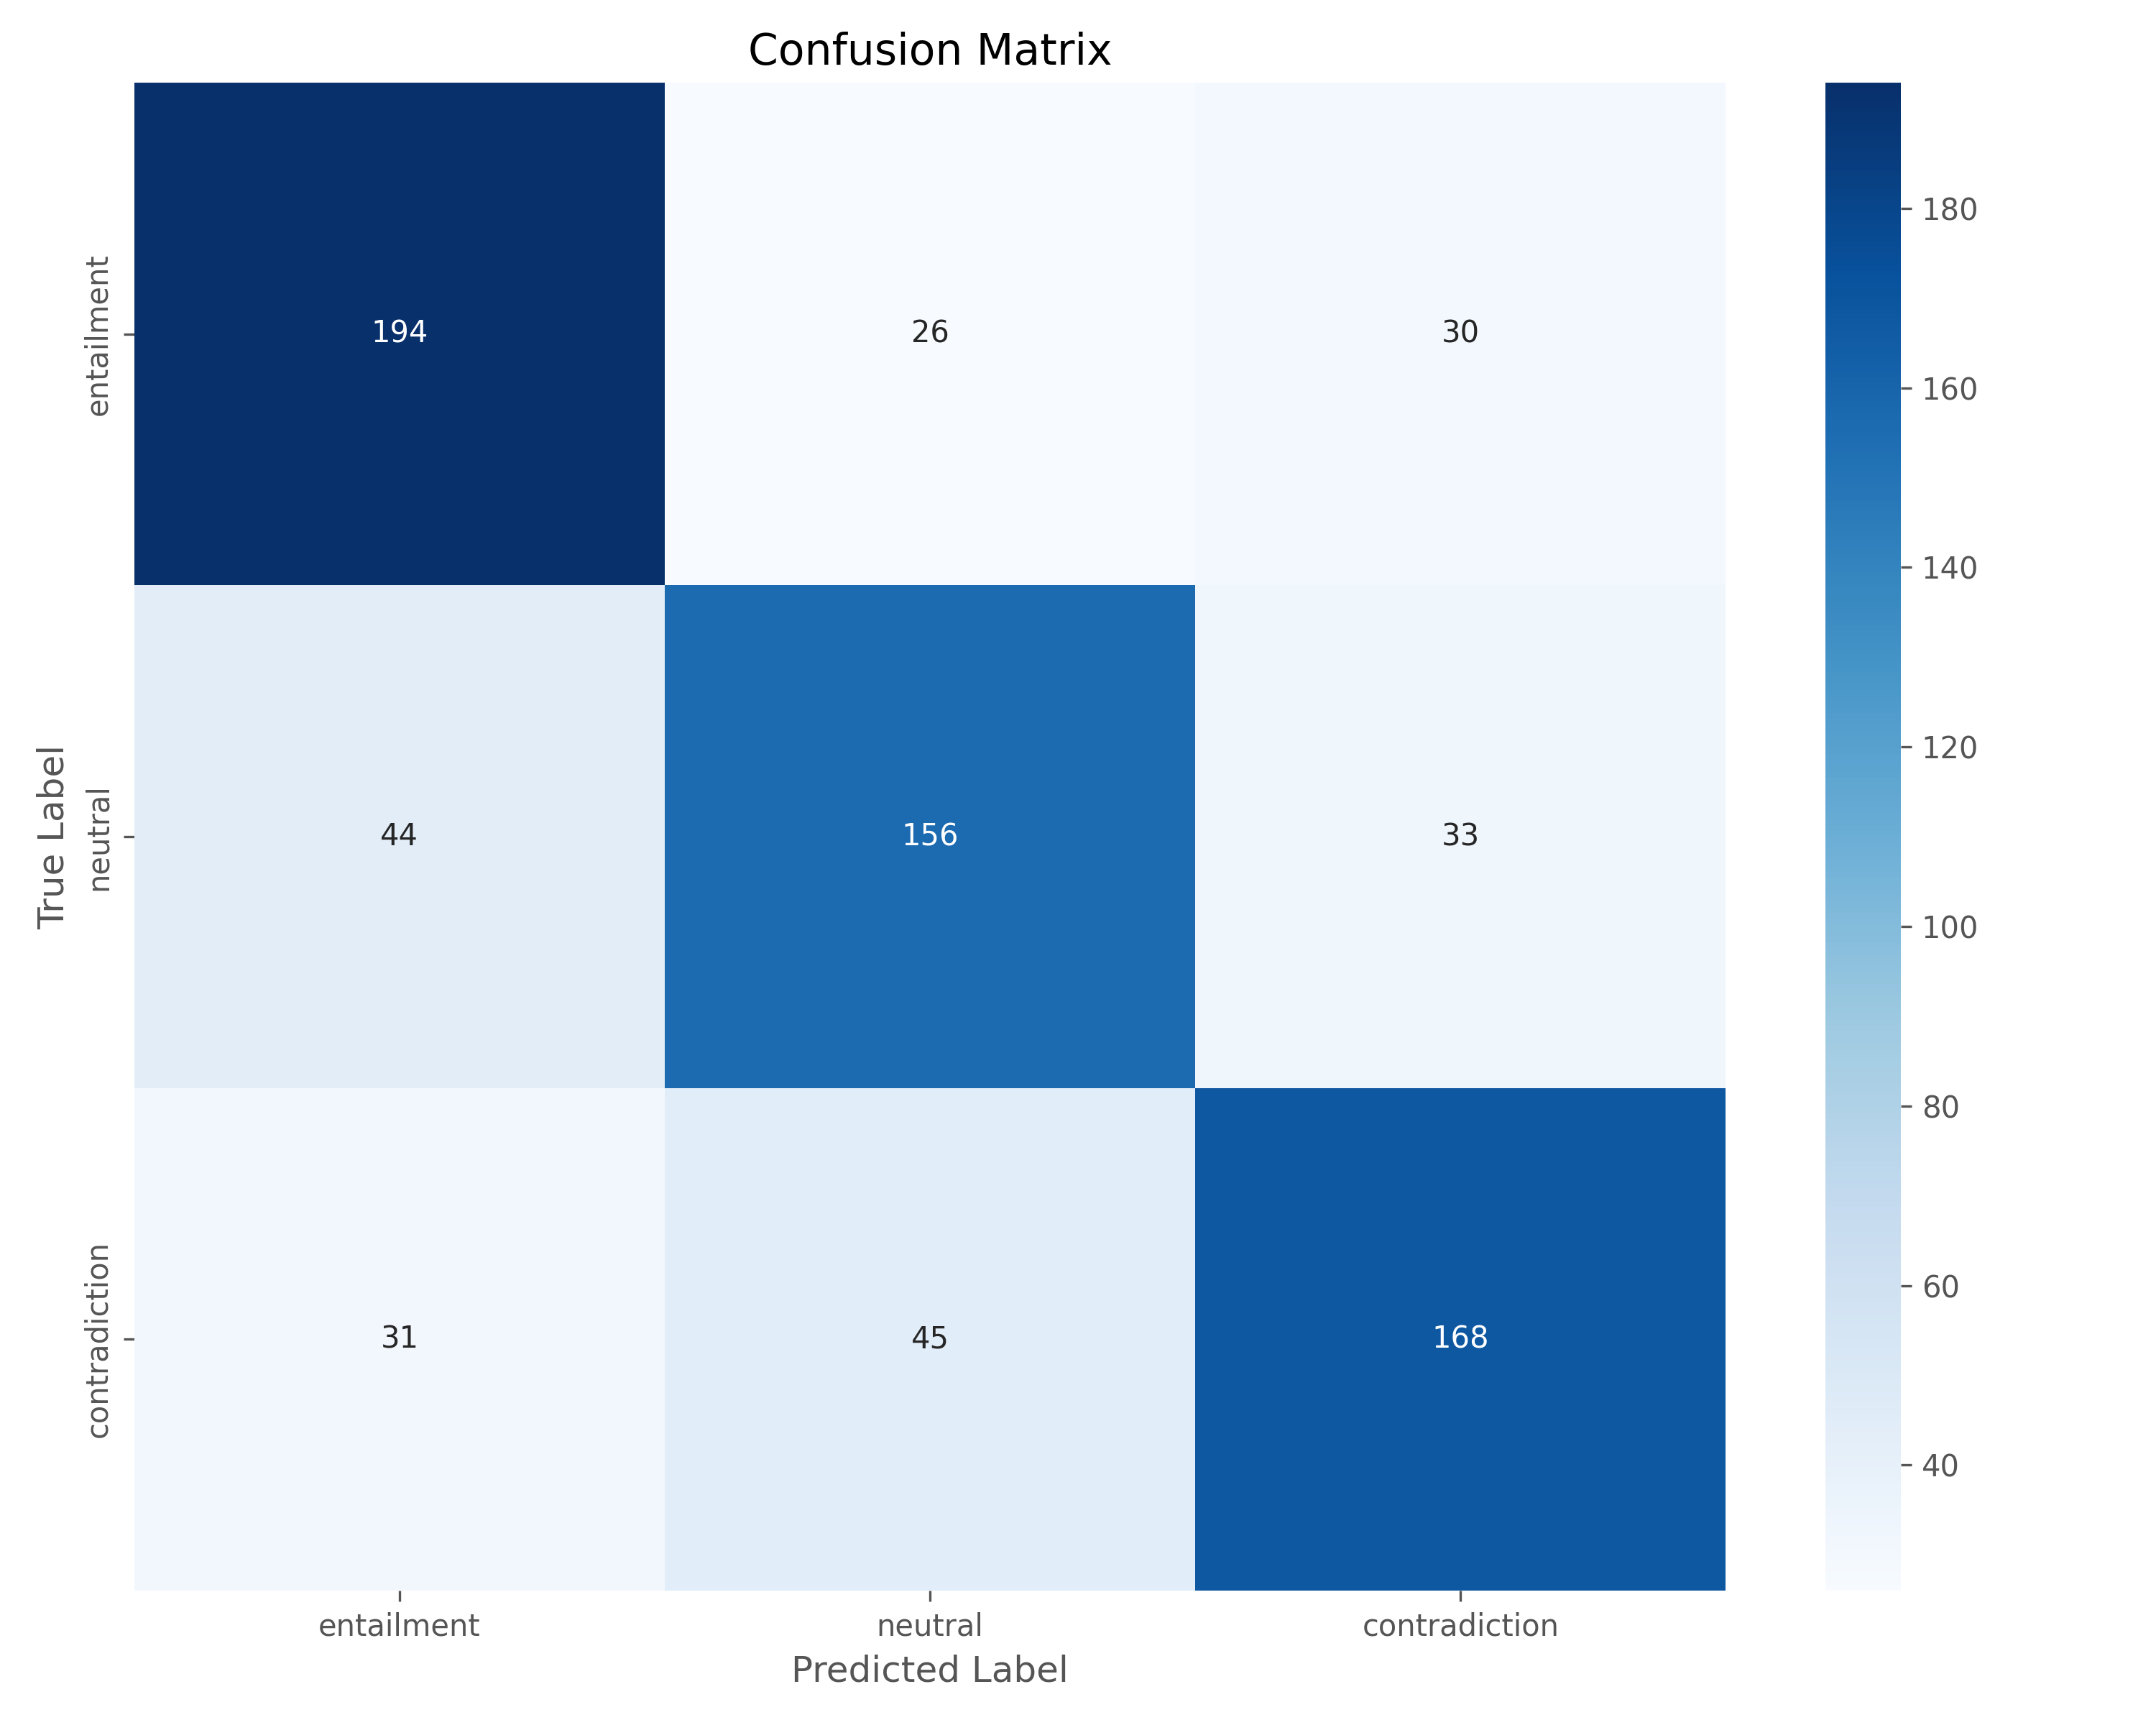


📊 Normalized Confusion Matrix:


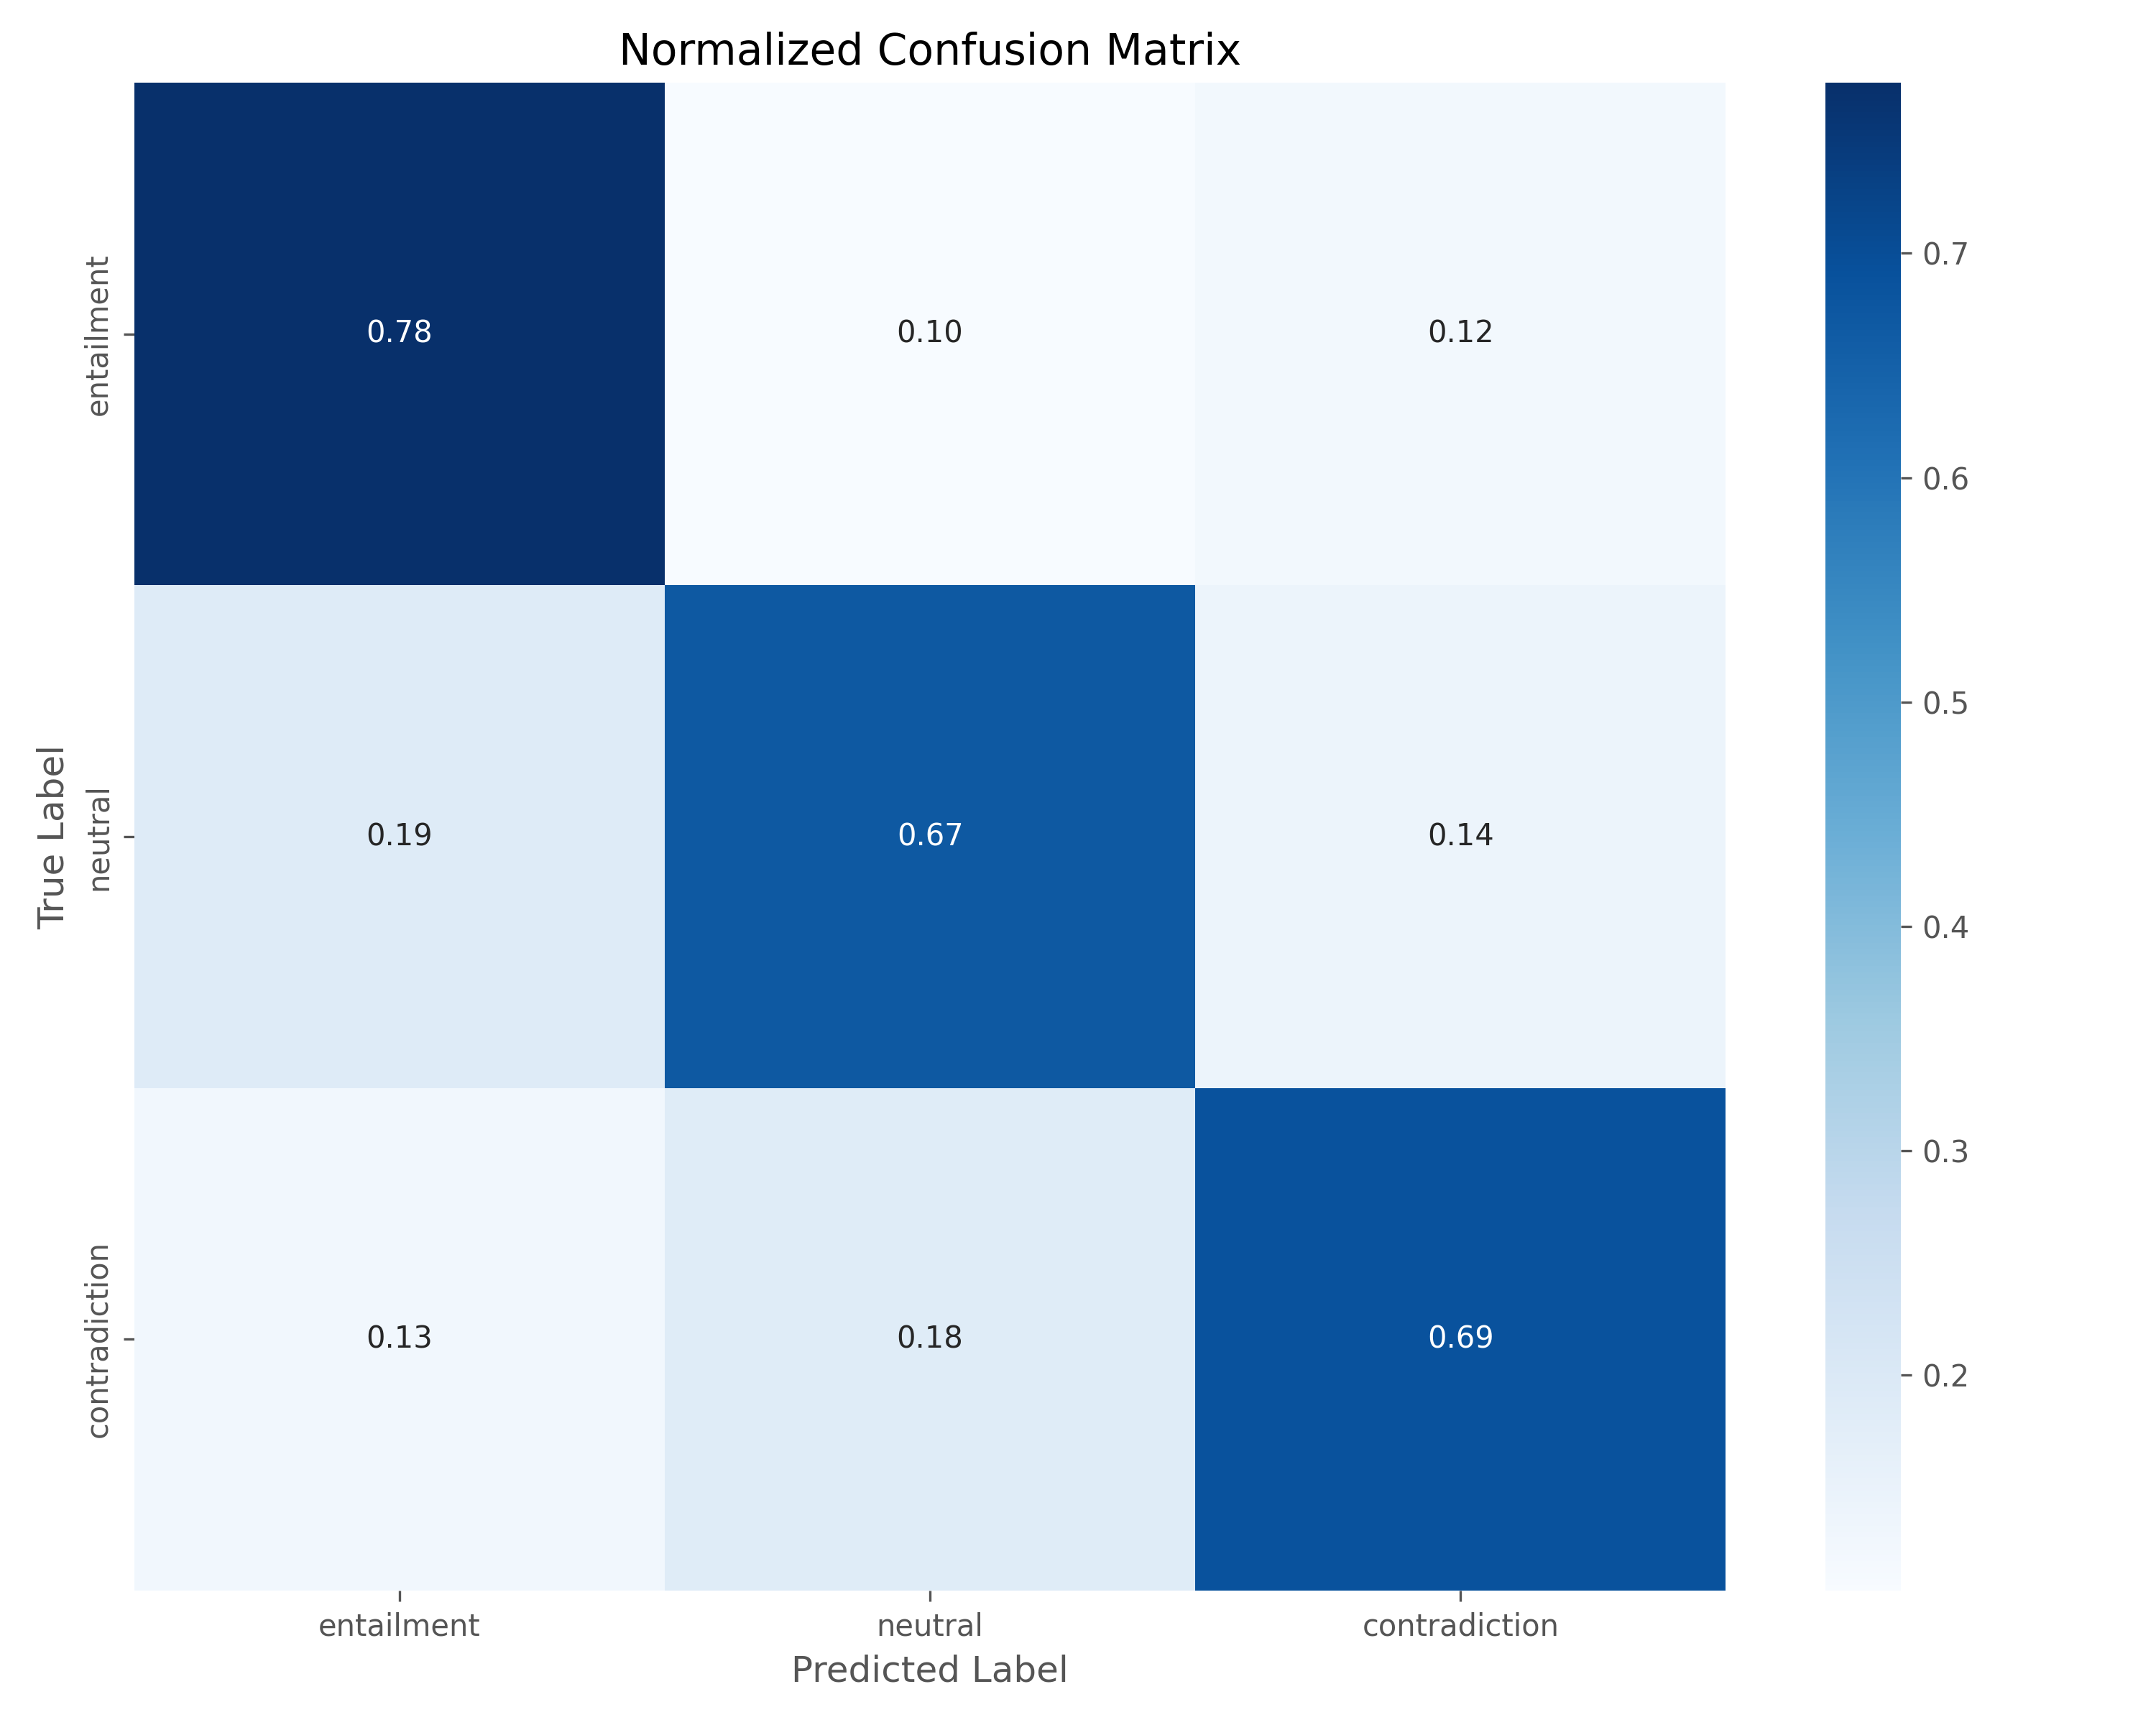


📉 ROC Curve:


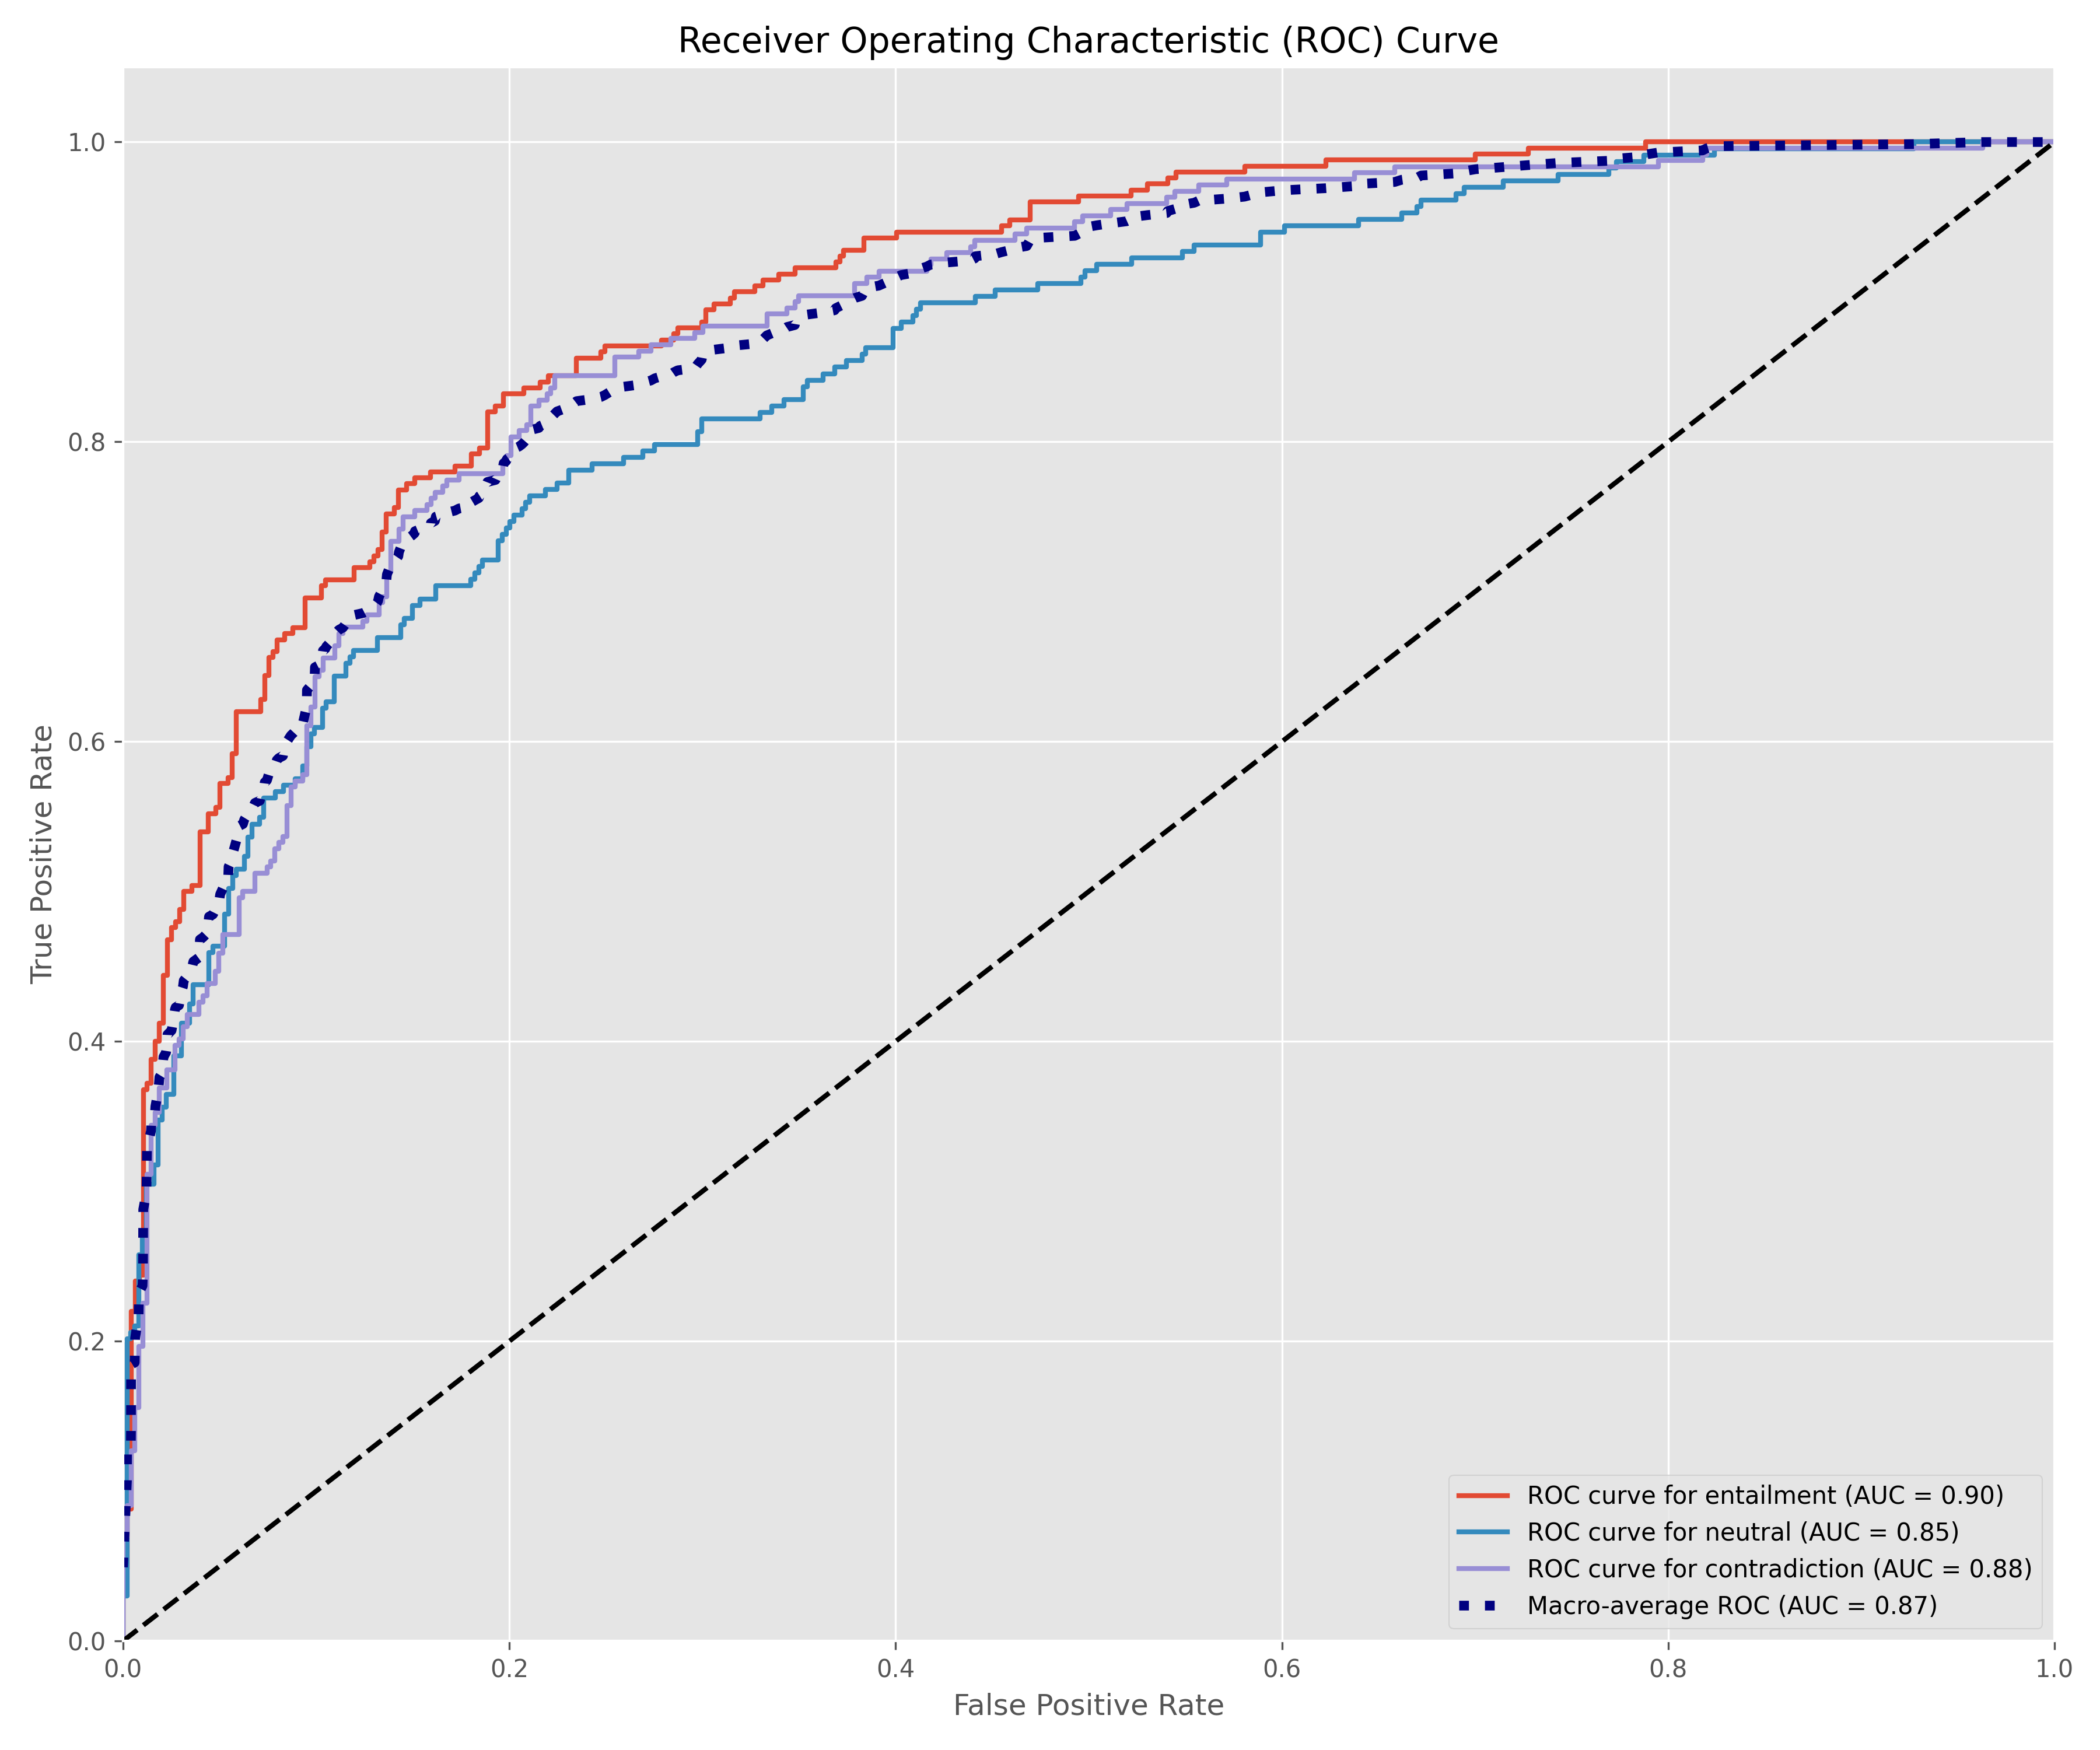

In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import torch
import pandas as pd
import os

# Set matplotlib to display inline in notebook
%matplotlib inline

# Configure plot styling for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

# Define a function to display all available plots for the model
def display_all_model_plots(output_dir):
    """
    Display all plots generated during model training and evaluation.
    
    Args:
        output_dir: Directory where model outputs and plots are saved
    """
    plots = {}
    
    # 1. Display training history plots
    plots_dir = os.path.join(output_dir, "plots")
    if not os.path.exists(plots_dir):
        plots_dir = output_dir  # Try looking directly in the output directory
    
    # Check and display loss curve
    loss_curve_path = os.path.join(plots_dir, "loss_curve.png")
    if os.path.exists(loss_curve_path):
        print("\n📈 Loss Curve:")
        display(Image(filename=loss_curve_path))
        plots["loss_curve"] = loss_curve_path
    
    # Check and display accuracy curve
    accuracy_curve_path = os.path.join(plots_dir, "accuracy_curve.png")
    if os.path.exists(accuracy_curve_path):
        print("\n📈 Accuracy Curve:")
        display(Image(filename=accuracy_curve_path))
        plots["accuracy_curve"] = accuracy_curve_path
        
    # 2. Display evaluation metrics plots
    metrics_dir = os.path.join(output_dir, "metrics")
    if not os.path.exists(metrics_dir):
        metrics_dir = output_dir  # Try looking directly in the output directory
    
    # Check and display confusion matrix
    confusion_matrix_path = os.path.join(metrics_dir, "confusion_matrix.png")
    if os.path.exists(confusion_matrix_path):
        print("\n📊 Confusion Matrix:")
        display(Image(filename=confusion_matrix_path))
        plots["confusion_matrix"] = confusion_matrix_path
    
    # Check and display normalized confusion matrix
    normalized_cm_path = os.path.join(metrics_dir, "confusion_matrix_normalized.png")
    if os.path.exists(normalized_cm_path):
        print("\n📊 Normalized Confusion Matrix:")
        display(Image(filename=normalized_cm_path))
        plots["confusion_matrix_normalized"] = normalized_cm_path
    
    # Check and display ROC curve
    roc_curve_path = os.path.join(metrics_dir, "roc_curve.png")
    if os.path.exists(roc_curve_path):
        print("\n📉 ROC Curve:")
        display(Image(filename=roc_curve_path))
        plots["roc_curve"] = roc_curve_path
    
    # Check and display precision-recall curve
    pr_curve_path = os.path.join(metrics_dir, "precision_recall_curve.png")
    if os.path.exists(pr_curve_path):
        print("\n📉 Precision-Recall Curve:")
        display(Image(filename=pr_curve_path))
        plots["precision_recall_curve"] = pr_curve_path
    
    # 3. Display metrics summary if available
    metrics_summary_path = os.path.join(metrics_dir, "metrics_summary.json")
    if os.path.exists(metrics_summary_path):
        import json
        with open(metrics_summary_path, "r") as f:
            metrics = json.load(f)
        
        print("\n📋 Model Performance Summary:")
        print(f"Accuracy: {metrics.get('accuracy', 'N/A')}")
        print(f"Macro Avg Precision: {metrics.get('macro_avg_precision', 'N/A')}")
        print(f"Macro Avg Recall: {metrics.get('macro_avg_recall', 'N/A')}")
        print(f"Macro Avg F1: {metrics.get('macro_avg_f1', 'N/A')}")
    
    roc_auc_path = os.path.join(metrics_dir, "roc_auc_scores.json")
    if os.path.exists(roc_auc_path):
        with open(roc_auc_path, "r") as f:
            roc_scores = json.load(f)
        
        print("\n📋 ROC AUC Scores:")
        for label, score in roc_scores.items():
            print(f"{label}: {score:.4f}")
    
    # If no plots were found, print a helpful message
    if not plots:
        print("No plots found in the specified directory. Here are files available in the output directory:")
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                if file.endswith(".png") or file.endswith(".json"):
                    rel_path = os.path.relpath(os.path.join(root, file), output_dir)
                    print(f"- {rel_path}")
    
    return plots

# Display all plots from the Kaggle working directory
model_output_dir = "/kaggle/working/nli_model_evaluation"
print(f"Looking for plots in: {model_output_dir}")

# Check if directory exists
if not os.path.exists(model_output_dir):
    print(f"Warning: The directory {model_output_dir} does not exist.")
    print("Available directories in /kaggle/working:")
    for item in os.listdir("/kaggle/working"):
        print(f"- {item}")
else:
    # List files in the directory to help debug
    print("Files in the directory:")
    for root, dirs, files in os.walk(model_output_dir):
        for file in files:
            rel_path = os.path.relpath(os.path.join(root, file), model_output_dir)
            print(f"- {rel_path}")
    
    # Now try to display the plots
    plots = display_all_model_plots(model_output_dir)